In [ ]:
import os
import sys
import numpy as np
import healpy as hp

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # Error boxes
from matplotlib.collections import PatchCollection # Error boxes
from plancklens import utils
from plancklens.qresp import get_response
from utils import matrixshow

sys.path.insert(0, './')
from one import *
import params as par
import bandpowers


# Error boxes   ：这个函数用于创建带有错误框的散点图,一个演示例子见WSL的/home/rabbit/workarea/1st work/2nd_ed/3rd_ed.ipynb
def make_error_boxes(ax, xdata, ydata, xerr, yerr, facecolor, edgecolor='None', alpha=0.5):
    errorboxes = []
    for x, y, xe, ye in zip(xdata, ydata, xerr.T, yerr.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())    #创建一个矩形（Rectangle）对象表示误差框：((左下角x,左下角y),宽度,高度)
        errorboxes.append(rect)
    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha, edgecolor=edgecolor)#使用PatchCollection创建一个包含所有误差框的图形集合
    # PatchCollection 允许您将多个图形对象集中在一起,并在图形中一起显示它们。

    # Add collection to axes
    ax.add_collection(pc)   #将其添加到指定的轴（ax）

In [2]:
# Parameters
#savePath = './'
#qe_keys = {
#           'p_eb':['k', 'EB'],
#           'p_te':['r', 'TE']
#           } # MV estimator
#btype = 'agr2'

# Parameters
savePath = './'      #保存文件的路径,设置为当前目录 './'
qe_keys = {   #键值对：估计量类型：[颜色,'类型描述']
            'ptt':['royalblue', 'TT'], # Temperature only
           'p_p':['green', 'Pol only'], # Polarization only
           #'p':['tomato', 'MV'], # MV estimator
#          'pee':['royalblue', 'EE']
 #          ,'p_p':['green', 'Pol']
 #          ,'p_eb':['tomato', 'EB']
          } 
btype = 'agr2'
# 定义见plancklens的bandpowers.py,给定了binning的上下限,根据不同研究用途决定分bin. 比如研究宇宙学的参数的时候,只需要做L<400,而lensing一般就是1000到2000最大。
# 这里是lensing reconstruct。lensing还可以研究去透镜、算宇宙学参数等,我们就要用不同的L的区域和范围,那我们肯定要在这个范围里面尽量的让它显示的好看一点,主要是为了让出图好看。

ptt
 [00:00:00]  ---------> 99%
p_p
 [00:00:00]  ---------> 99%


(0.1, 3.0)

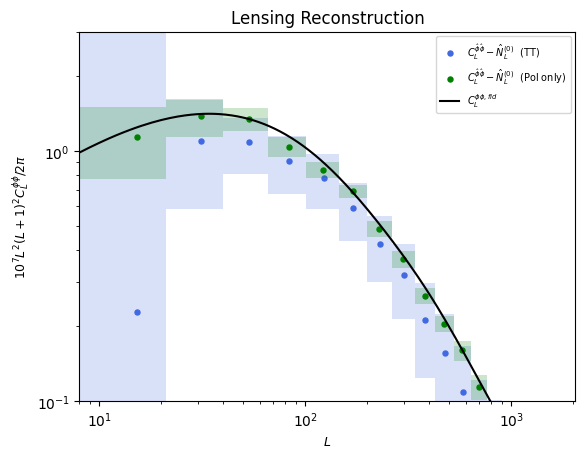

In [3]:
# Plot Reconstructed power spectrum
fig, ax = plt.subplots()

for key in qe_keys.keys():  #ptt, p_p, p
    print(key)
    bp = bandpowers.ffp10_binner(key, key, par, btype, ksource='p')  #估计器&binning
    bells = bp.bin_lavs
    bpower = (bp.get_dat_bandpowers() - bp.get_rdn0() - bp.get_n1()) * bp.get_bmmc()   #得到无偏功率谱估计量, 其中get_bmmc(): multiplicative MC correction
#    bpower = (bp.get_dat_bandpowers() - bp.get_rdn0())
    
    # Potential Estimator
    yerr = np.sqrt(bp.get_cov().diagonal())
    l, u, c = bandpowers.get_blbubc(btype)    #下边界,上边界,band中心
    xerr = np.stack([bp.bin_lavs - l, u - bp.bin_lavs + 1])    #xerr什么样的
    make_error_boxes(ax, bells, bpower, xerr, np.stack([yerr, yerr]), facecolor=qe_keys[key][0], edgecolor='None', alpha=0.2)   #plot error boxes
    ax.scatter(bells, bpower, label='$C_L^{\hat\phi\hat\phi}-\hat N_L^{(0)}$  (%s)' % qe_keys[key][1], c=qe_keys[key][0], s=13) #plot binned cl

# fiducial lensing power spectrum
ax.plot(np.arange(2049), bp.clkk_fid, label=r'$C_L^{\phi\phi, fid}$', c='k')
ax.semilogx()
ax.semilogy()
ax.set_title('Lensing Reconstruction', fontsize=12)
ax.set_xlabel(r'$L$', fontsize=9)
ax.set_ylabel(r'$10^7 L^2 (L + 1)^2 C_L^{\phi\phi}/2\pi$', fontsize=9)
ax.legend(loc='upper right', fontsize=7)
ax.set_xlim(l.min(), u.max())
ax.set_ylim(0.1, 3.)

ptt
 [00:00:00]  ---------> 99%
SNR of ptt is 27.96212362290554
SNR of ptt is 10.305984803895049
p_p
 [00:00:00]  ---------> 99%
SNR of p_p is 39.914530778453354
SNR of p_p is 41.03291337710182


(8, 2048)

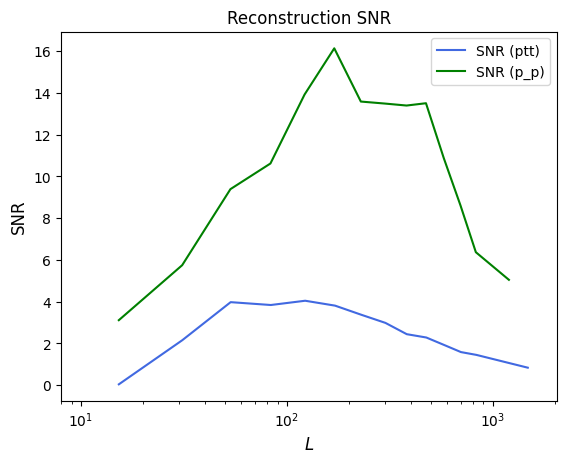

In [4]:
# Plot SNR plot
fig, ax = plt.subplots()
for qe_key in qe_keys.keys():
    print(qe_key)
    bp = bandpowers.ffp10_binner(qe_key, qe_key, par, btype, ksource='p')
    cov = bp.get_cov()
    signal = (bp.get_dat_bandpowers() - bp.get_rdn0() - bp.get_n1()) * bp.get_bmmc() #bp.get_bmmc(): Binned multiplicative MC correction
#    signal = bp.get_fid_bandpowers()
    l, u, c = bandpowers.get_blbubc(btype)
    SNRs = signal / np.sqrt(cov.diagonal())    #信噪比定义

    ax.plot(bp.bin_lavs, SNRs, c=qe_keys[qe_key][0], label='SNR (%s)' % qe_key)
    #two method to calculate SNR
    print('SNR of', qe_key, 'is', np.dot(np.dot(signal, np.matrix(cov).I), signal)[0,0] ** 0.5)   #Fisher method, SNR=sqrt(C*Cov^-1*C),见Liu Jinyi文章(3.15)式，在存在foreground等因素的影响下相比下式更精确.这里[0,0]是因为点积结果为[[SNR]] 
    print('SNR of', qe_key, 'is', np.sqrt(sum(signal**2 / cov.diagonal())))    #误差传递公式，仅考虑auto-correlation(即对角元素,即方差)
#    print(cov)
ax.semilogx()
ax.set_title('Reconstruction SNR', fontsize=12)
ax.set_xlabel(r'$L$', fontsize=12)
ax.set_ylabel('SNR', fontsize=12)
ax.legend()
ax.set_xlim(l.min(), 2048)

ptt
 [00:00:00]  ---------> 99%
p_p
 [00:00:00]  ---------> 99%


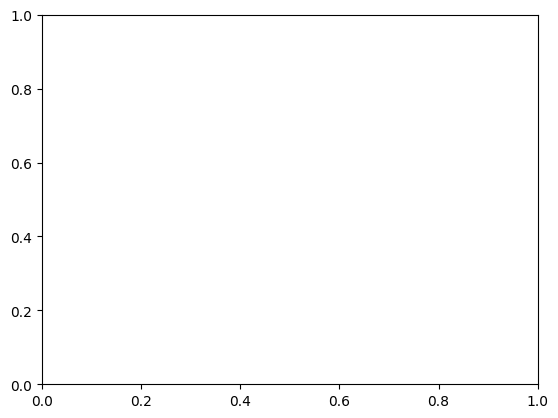

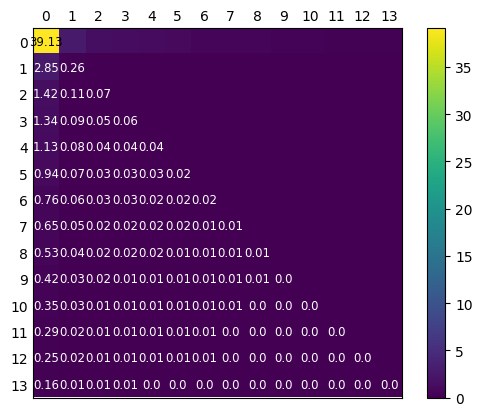

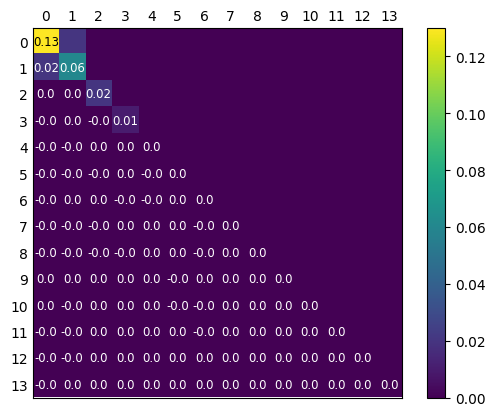

In [5]:
#plot covariance matrix
fig, ax = plt.subplots()
for qe_key in qe_keys.keys():
    print(qe_key)
    bp = bandpowers.ffp10_binner(qe_key, qe_key, par, btype, ksource='p')
    cov = bp.get_cov()
    matrixshow(cov,os.path.join(ALILENS, f'cov_matrix_{qe_key}.pdf'))